# Linear Predictive Coding with Tensorflow

First, we would like to create a two-layered linear predictive coding model using tensorflow and keras. It seems likely that due to the unique nature of the state-and-weights-estimation, we need to somewhat start at the beginning. It seems to make the most sense to first fit the model using numpy arrays and then transform it to tensorflow tensors.

## Input structure

### Input structure -- Raw

In [1]:
import tensorflow as tf

In [2]:
cifar_data = tf.keras.datasets.cifar10.load_data()

In [3]:
cifar_pictures = cifar_data[0][0]

In [146]:
def get_bw(cifar_pictures):
    return cifar_pictures.mean(axis = 3)

In [147]:
cifar_bw = get_bw(cifar_pictures)

In [148]:
cifar_bw.shape

(50000, 32, 32)

We therefore consider these 50000 different 32x32 black-and-white pictures as our input.

In [25]:
import plotnine as gg
import numpy as np
example = cifar_bw[np.random.choice(range(cifar_bw.shape[0]), size = 1)[0]]

NameError: name 'cifar_bw' is not defined

In [26]:
import pandas as pd
example_p = pd.DataFrame({
    'x': list(range(example.shape[0]))*example.shape[1],
    'y': np.repeat(list(range(example.shape[1])), repeats = example.shape[0]),
    'bw': example.flatten()
})

NameError: name 'example' is not defined

In [151]:
picture = (gg.ggplot(example_p, gg.aes(x = 'x', y = 'y', fill = 'bw')) + 
          gg.geom_tile() + 
          gg.theme_void() + 
          gg.theme(legend_position = 'none') +
          gg.scale_fill_gradient(low = 'white', high = 'black'))

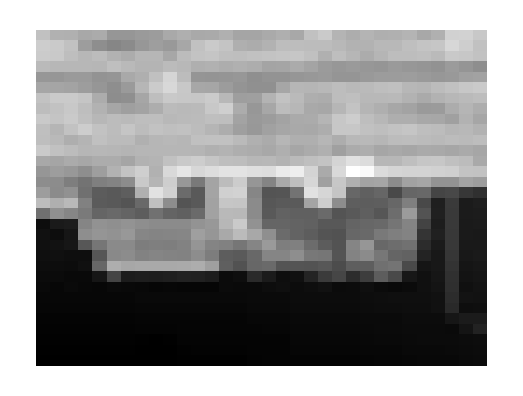

<ggplot: (-9223363272876077326)>

In [152]:
picture

In [162]:
example_color = cifar_pictures[np.random.choice(cifar_pictures.shape[0])]

In [168]:
example_color[:,:,2]

array([[230, 220, 211, ..., 245, 247, 253],
       [236, 227, 216, ..., 252, 253, 255],
       [238, 227, 216, ..., 251, 252, 255],
       ...,
       [155, 149, 143, ..., 162, 162, 161],
       [154, 149, 144, ..., 158, 158, 156],
       [162, 155, 151, ..., 153, 151, 149]], dtype=uint8)

In [169]:
example_color_p = pd.DataFrame({
    'x': list(range(example_color.shape[0]))*example_color.shape[1],
    'y': np.repeat(list(range(example_color.shape[1])), repeats = example_color.shape[0]),
    'r': example_color[:,:,0].flatten(),
    'g': example_color[:,:,1].flatten(),
    'b': example_color[:,:,2].flatten()
})
def hex_2(i):
    hex_2 = hex(i)[2:]
    assert len(hex_2) <= 2
    if len(hex_2) == 1:
        hex_2 = '0' + hex_2
    return str(hex_2)
example_color_p['rgb'] = [
    '#' + hex_2(r) + hex_2(g) + hex_2(b) for r, g, b in zip(example_color_p['r'],
                                                     example_color_p['g'],
                                                     example_color_p['b'])
]

In [171]:
color_picture = (gg.ggplot(example_color_p, gg.aes(x = 'x', y = 'y', fill = 'rgb')) + 
                gg.geom_tile() + 
                gg.theme_void() + 
                gg.theme(legend_position = 'none') + 
                gg.scale_fill_manual(
                    values = {key: key for key in example_color_p['rgb'].unique()}
                ))

In [204]:
data = cifar_pictures[range(10),:,:,:]
image_id = list(np.repeat(list(range(10)),repeats = 32*32))
flattened_x = list(np.repeat(list(range(32)), repeats = 32))*10
flattened_y = list(range(32))*32*10

In [199]:
len(flattened_x)

10240

In [215]:
dataframe = pd.DataFrame({
            'image_id': np.array(image_id),
            'x': np.array(flattened_x),
            'y': np.array(flattened_y),
            'r': data[:,:,:,0].flatten(),
            'g': data[:,:,:,1].flatten(),
            'b': data[:,:,:,2].flatten(),
            'bw': data.mean(axis=3).flatten()
        })
dataframe['rgb'] = np.array([
    '#' + hex_2(r) + hex_2(g) + hex_2(b) for r, g, b in zip(dataframe['r'],
                                                     dataframe['g'],
                                                     dataframe['b'])
])
dataframe['rgb_bw'] = np.array([
            '#' + hex_2(int(bw))*3 for bw in dataframe['bw']
        ])

In [8]:
dataframe.head()

NameError: name 'dataframe' is not defined

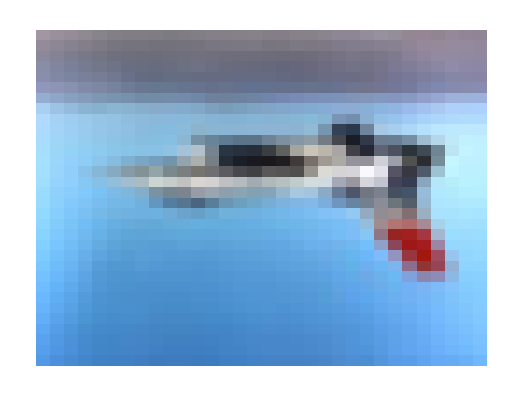

<ggplot: (8763978730237)>

In [172]:
color_picture

### Input structure -- level 1

The same should be extended to a couple of pictures, thus handling a four-dimensional array, which we would like to flatten. Parallely, the labels, though not important for the purpose of the analysis itself, would contribute to an intuition behind these pictures.

In [4]:
import predicode as pc

In [5]:
cifar = pc.ImageData(cifar_pictures)

In [6]:
df = cifar.dataframe(range(10))

In [18]:
df.head()

image_id  x  y   r   g   b         bw      rgb   rgb_bw
0         0  0  0  59  62  63  61.333333  #3b3e3f  #3d3d3d
1         0  1  0  43  46  45  44.666667  #2b2e2d  #2c2c2c
2         0  2  0  50  48  43  47.000000  #32302b  #2f2f2f
3         0  3  0  68  54  42  54.666667  #44362a  #363636
4         0  4  0  98  73  52  74.333333  #624934  #4a4a4a

In [19]:
labels = cifar_data[0][1]

In [34]:
labels[range(10)]
lab = next(iter(labels[range(10)]))
cifar_labels[int(lab[0])]

'frog'

In [35]:
cifar_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
                'dog', 'frog', 'horse', 'ship', 'truck']
df_labels = pd.DataFrame({
    'label': [int(lab[0]) for lab in labels[range(10)]],
    'label_text': np.array([cifar_labels[int(lab[0])] for lab in labels[range(10)]])
})

In [41]:
df_labels.head()

label  label_text
0      6        frog
1      9       truck
2      9       truck
3      4        deer
4      1  automobile

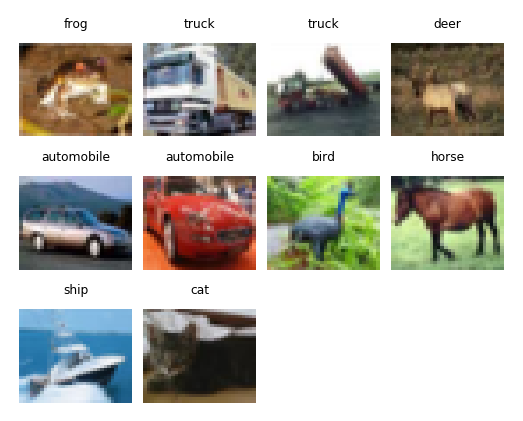

<ggplot: (8794444281927)>

In [39]:
(gg.ggplot(df, gg.aes(x = 'x', y = 'y', fill = 'rgb')) + 
                gg.geom_tile() + 
                gg.theme_void() + 
                gg.theme(legend_position = 'none') + 
                gg.scale_fill_manual(
                    values = {key: key for key in df['rgb'].unique()}
                ) + 
                gg.facet_wrap('image_id', labeller = lambda x: df_labels['label_text'][int(x)]) + 
                gg.scale_y_reverse())

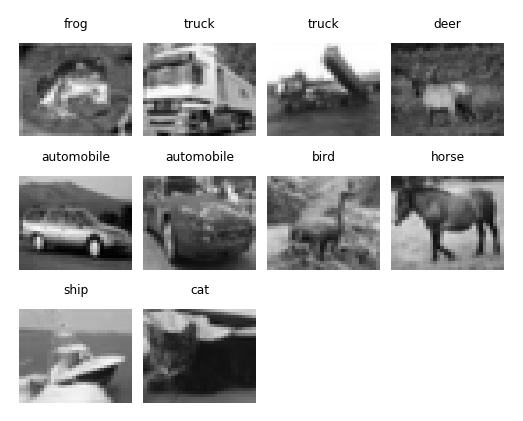

<ggplot: (-9223363242411426409)>

In [40]:
(gg.ggplot(df, gg.aes(x = 'x', y = 'y', fill = 'rgb_bw')) + 
                gg.geom_tile() + 
                gg.theme_void() + 
                gg.theme(legend_position = 'none') + 
                gg.scale_fill_manual(
                    values = {key: key for key in df['rgb_bw'].unique()}
                ) + 
                gg.facet_wrap('image_id', labeller = lambda x: df_labels['label_text'][int(x)]) + 
                gg.scale_y_reverse())

### Input structure -- level 2

In [1]:
import predicode as pc

In [2]:
cifar = pc.Cifar10()

In [3]:
cifar.dataframe(n_random = 12).head()
len(cifar.dataframe(n_random = 12))
cifar.labels.head()

label  label_text
0      6        frog
1      9       truck
2      9       truck
3      4        deer
4      1  automobile

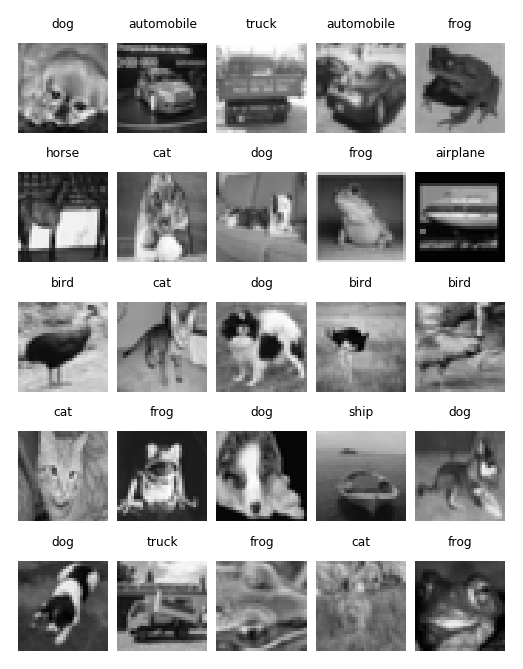

<ggplot: (-9223363243287232035)>

In [4]:
cifar.pictures(n_random = 25)

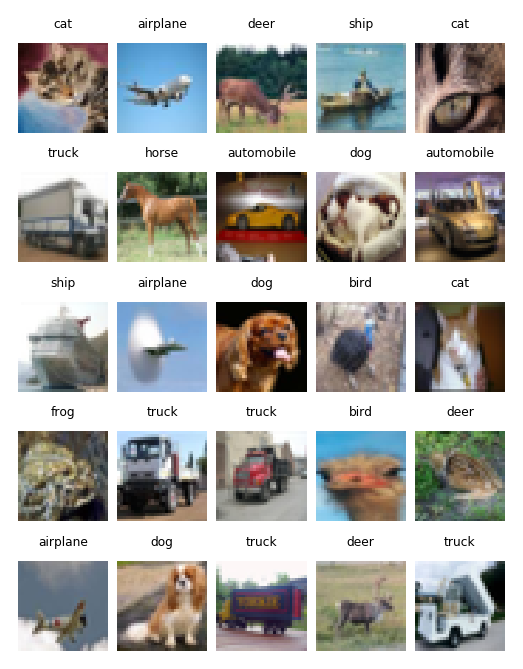

<ggplot: (-9223363243276476286)>

In [5]:
cifar.pictures(n_random = 25, mode = 'color')